# Imports

In [1]:
import sys
sys.path.append('../src')

from data_manager import (
    get_image_paths,
    get_images,
    get_labels
)
from pipelines import preprocessing_pipeline
from pipelines import classifier_pipeline

import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm 

import cv2
from skimage import io, color, transform, feature
from skimage.feature import hog, local_binary_pattern

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix
)
from sklearn.svm import SVC

root_path = '../'
ck_data_path = os.path.join(root_path, 'data/CK+48')
jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

In [16]:
ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck', verbose=True)
jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

  4%|▎         | 36/981 [00:00<00:02, 354.45it/s]

100%|██████████| 981/981 [00:04<00:00, 237.77it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)


100%|██████████| 213/213 [00:00<00:00, 757.10it/s]

Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)


# HOG Features Building with CK+48 dataset

### Gradients

**HOG paper**
- Simple 1-D [−1, 0, 1] masks at σ=0 work best
- Including signed gradients decreases the
performance, even when the number of bins is also doubled
to preserve the original orientation resolution.

In [23]:
def compute_gradients(image):
    """
    Computes gradient magnitude and gradient direction of an image
    based on Sobel filters.

    Parameters
    ----------
    image:
        Input image of size (h, w)

    Returns
    -------
    magnitude:
        Image of size (h, w) with gradient magnitude
    direction:
        Image of size (h, w) with gradient direction
    """

    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)

    magnitude, direction = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    return magnitude, direction


##### ck+

100%|██████████| 981/981 [00:04<00:00, 208.22it/s]


Text(0.5, 1.0, 'Gradient direction')

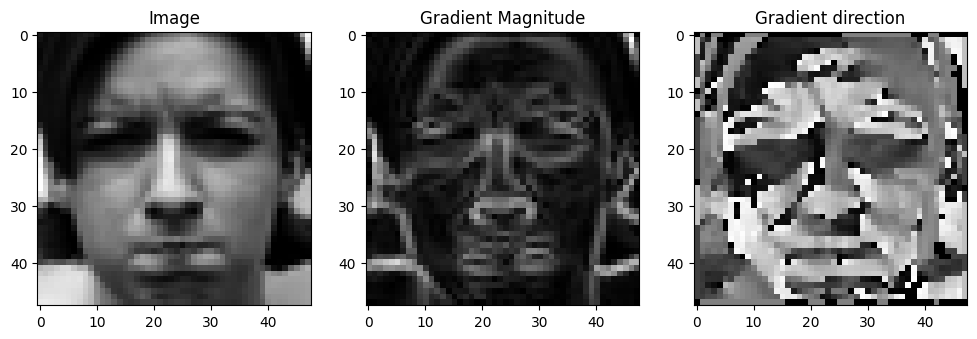

In [24]:

ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck')

ck_image = ck_images[0]
ck_magnitude, ck_direction = compute_gradients(ck_image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(ck_image, cmap='gray')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(ck_magnitude, cmap='gray')
plt.title('Gradient Magnitude')

plt.subplot(1, 3, 3)
plt.imshow(ck_direction, cmap='gray')

plt.savefig('ck-gradients.png')
plt.title('Gradient direction')

##### jaffe

100%|██████████| 213/213 [00:00<00:00, 511.75it/s]


Text(0.5, 1.0, 'Gradient direction')

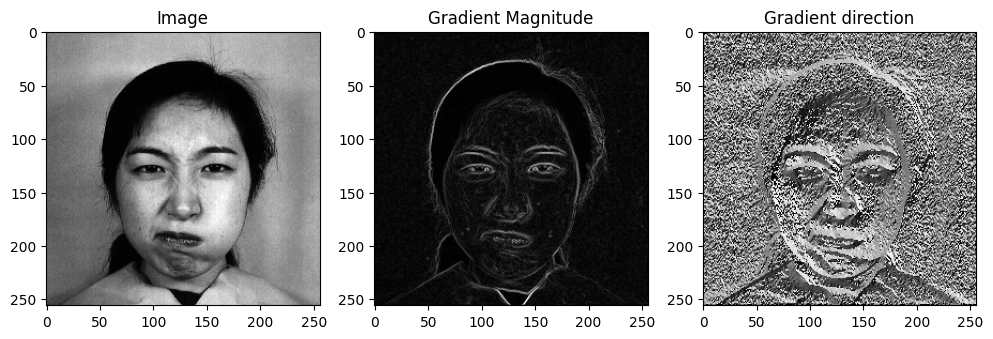

In [25]:
jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')
jaffe_image = jaffe_images[0]
jaffe_magnitude, jaffe_direction = compute_gradients(jaffe_image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(jaffe_image, cmap='gray')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(jaffe_magnitude, cmap='gray')
plt.title('Gradient Magnitude')

plt.subplot(1, 3, 3)
plt.imshow(jaffe_direction, cmap='gray')

plt.savefig('jaffe-gradients.png')
plt.title('Gradient direction')

### Histograms

In [21]:
def compute_histograms(magnitude, direction, cell_size=(8,8), bins=9, plot=False):

    direction = np.mod(direction, 180)

    cells_x = magnitude.shape[1] // cell_size[0]
    cells_y = magnitude.shape[0] // cell_size[1]

    # print(cells_x) # 6
    # print(cells_y) # 6

    histograms = []

    for i in range(cells_y):
        for j in range(cells_x):

            cell_magnitude = magnitude[
                i * cell_size[1]: (i + 1) * cell_size[1], 
                j * cell_size[0]: (j + 1) * cell_size[0]
            ]
            cell_direction = direction[
                i * cell_size[1]: (i + 1) * cell_size[1], 
                j * cell_size[0]: (j + 1) * cell_size[0]
            ]

            histogram, _ = np.histogram(cell_direction, bins=bins, range=(0, 180), weights=cell_magnitude)
            histograms.append(histogram)

    histograms = np.array(histograms)

    if plot:

        fig, axs = plt.subplots(cells_x,  cells_y, figsize=(15, 15), sharex=True, sharey=True)

        for i in range(cells_y):
            for j in range(cells_x):
                axs[i, j].bar(np.arange(bins)*20, histograms[i*cells_y+j], width=20, align='edge')
                axs[i, j].set_title(f'Cell ({j}, {i})')
                axs[i, j].tick_params(axis='x', rotation=45)
        
        plt.xticks(np.arange(0, 10 * 20, 20))
        plt.tight_layout()         

    return histograms, cells_x, cells_y


##### ck+

[]

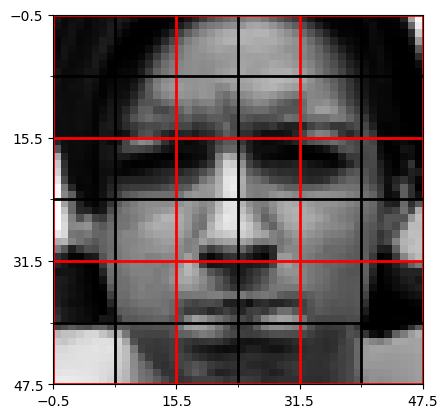

In [32]:
fig, ax = plt.subplots()

ax.imshow(ck_images[0], cmap='gray')

ax.set_xticks(np.arange(-0.5, 48, 8), minor=True)
ax.set_yticks(np.arange(-0.5, 48, 8), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)

ax.set_xticks(np.arange(-0.5, 48, 2*8), minor=False)
ax.set_yticks(np.arange(-0.5, 48, 2*8), minor=False)
ax.grid(which="major", color="red", linestyle='-', linewidth=2)

plt.plot()


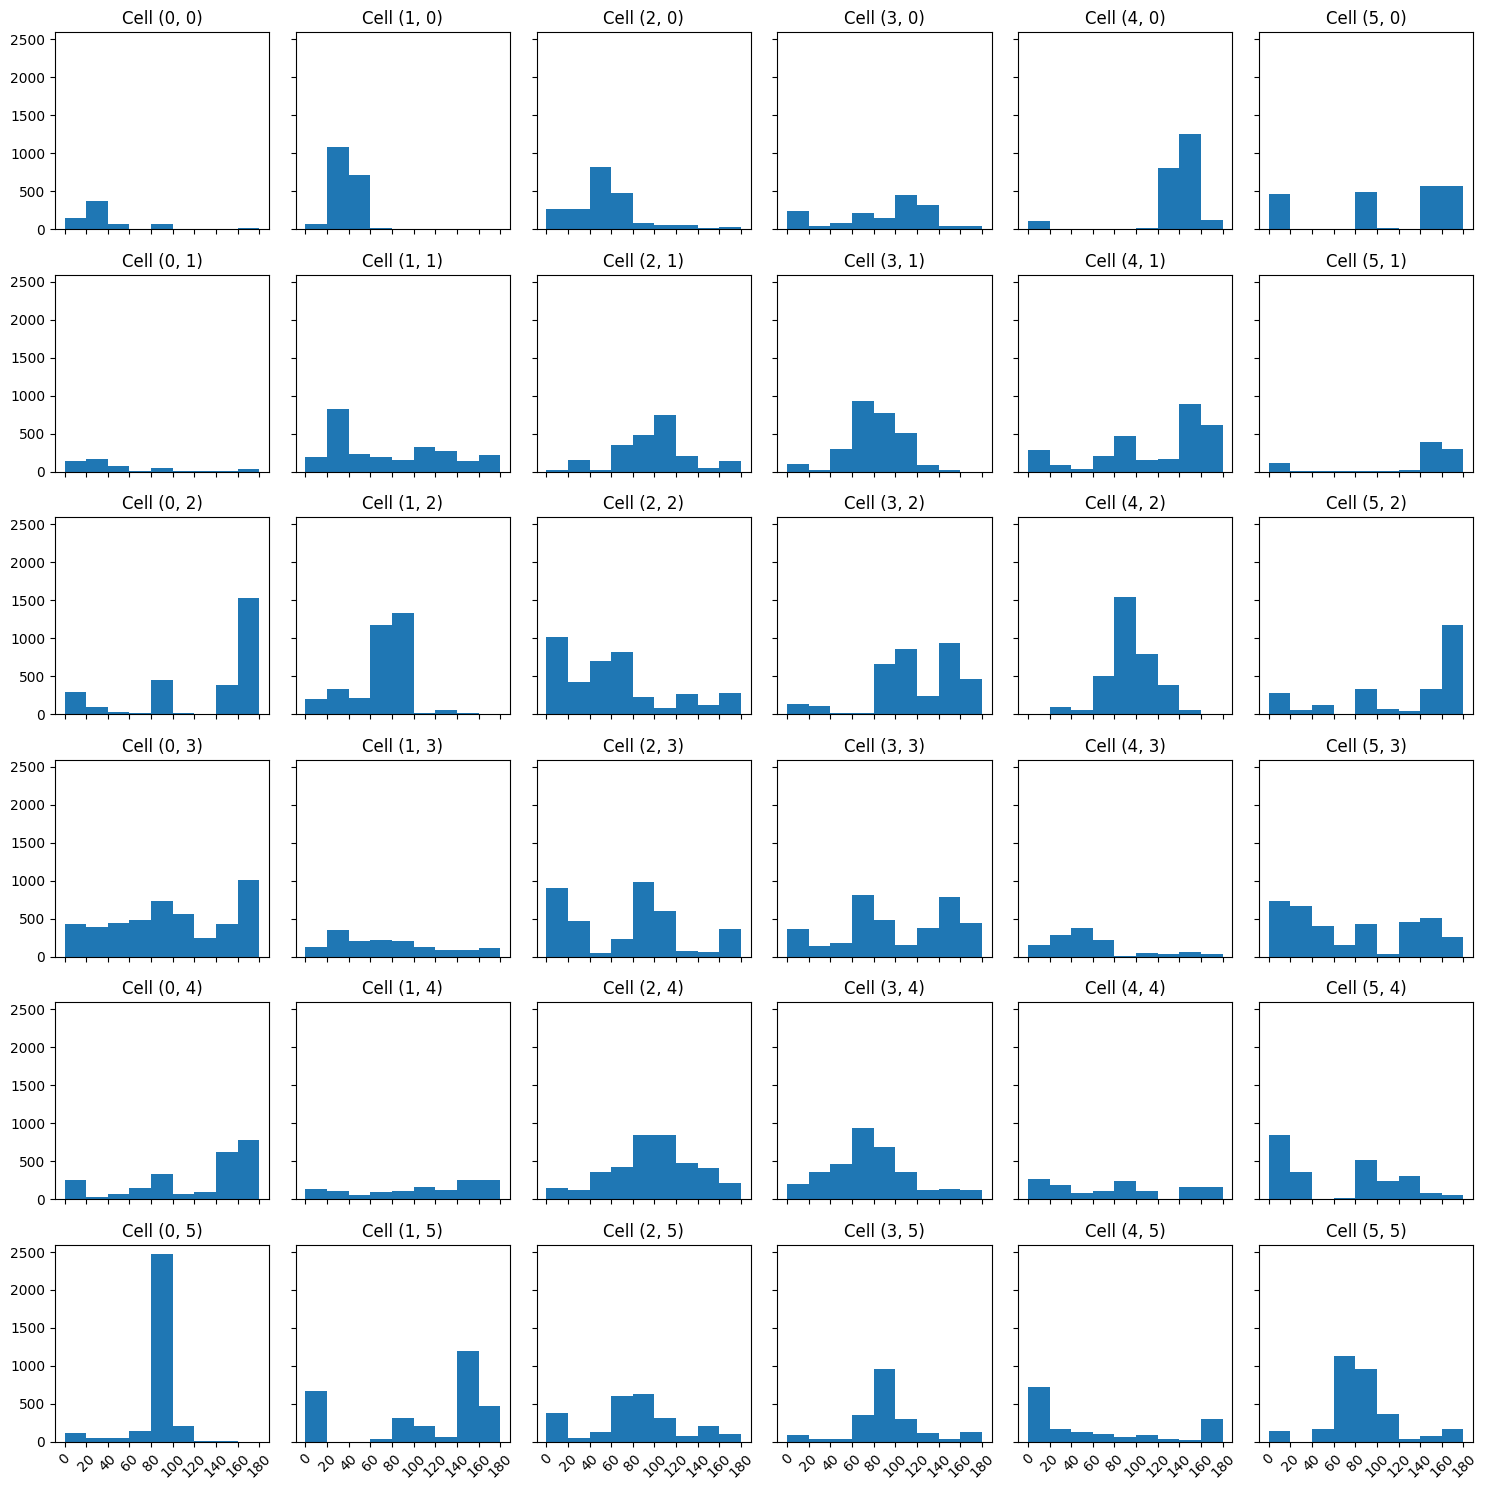

In [26]:
cell_size = (8, 8),
bins = 9

ck_histograms, ck_cells_x, ck_cells_y = compute_histograms(ck_magnitude, ck_direction, cell_size=(8,8), bins=9, plot=True)
plt.savefig('ck-histogram.png')
plt.show()
# histograms[0] corresponds to cell(0, 0)
# histograms[1] corresponds to cell(0, 1)
# ...

# histograms.shape # (36, 9)

##### JAFFE

[]

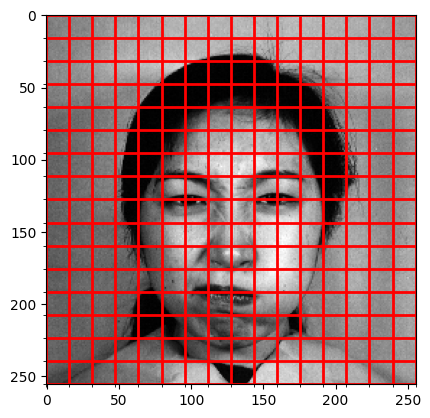

In [38]:
fig, ax = plt.subplots()

ax.imshow(jaffe_images[0], cmap='gray')

ax.set_xticks(np.arange(-0.5, 256, 16), minor=True)
ax.set_yticks(np.arange(-0.5, 256, 16), minor=True)
ax.grid(which="minor", color="red", linestyle='-', linewidth=2)

plt.savefig('figures/jaffe-cells-view.png')
plt.plot()


In [ ]:
cell_size = (16, 16)
bins=6

jaffe_histograms, jaffe_cells_x, jaffe_cells_y = compute_histograms(
    jaffe_magnitude, jaffe_direction, 
    cell_size = (16, 16), bins=6,
    plot=True
)
plt.savefig('jaffe-histogram.png')
plt.show()

### Block normalization

In [ ]:
def block_normalization(histograms, cells_x, cells_y, block_size=(2,2), plot=False):

    blocks_x = cells_y - block_size[0] + 1
    blocks_y = cells_x - block_size[1] + 1

    original_shape = histograms.shape
    histograms = histograms.reshape(cells_x, cells_y, histograms.shape[1])

    normalized_histograms = np.zeros_like(histograms)

    for i in range(blocks_y):
        for j in range(blocks_x):

            block = histograms[i:i+block_size[1], j:j+block_size[0], :]
            block_norm = np.linalg.norm(block)

            if block_norm != 0:
                normalized_block = block / block_norm
            else:
                normalized_block = block

            normalized_histograms[i:i+block_size[1], j:j+block_size[0], :] = normalized_block
    
    normalized_histograms = normalized_histograms.reshape(original_shape)

    if plot:

        histograms = normalized_histograms

        fig, axs = plt.subplots(cells_x,  cells_y, figsize=(15, 15), sharex=True, sharey=True)

        for i in range(cells_y):
            for j in range(cells_x):
                axs[i, j].bar(np.arange(9)*20, histograms[i*cells_y+j], width=20, align='edge')
                axs[i, j].set_title(f'Cell ({j}, {i})')
                axs[i, j].tick_params(axis='x', rotation=45)
        
        plt.xticks(np.arange(0, 10 * 20, 20))
        plt.tight_layout()         

    return normalized_histograms


##### ck+

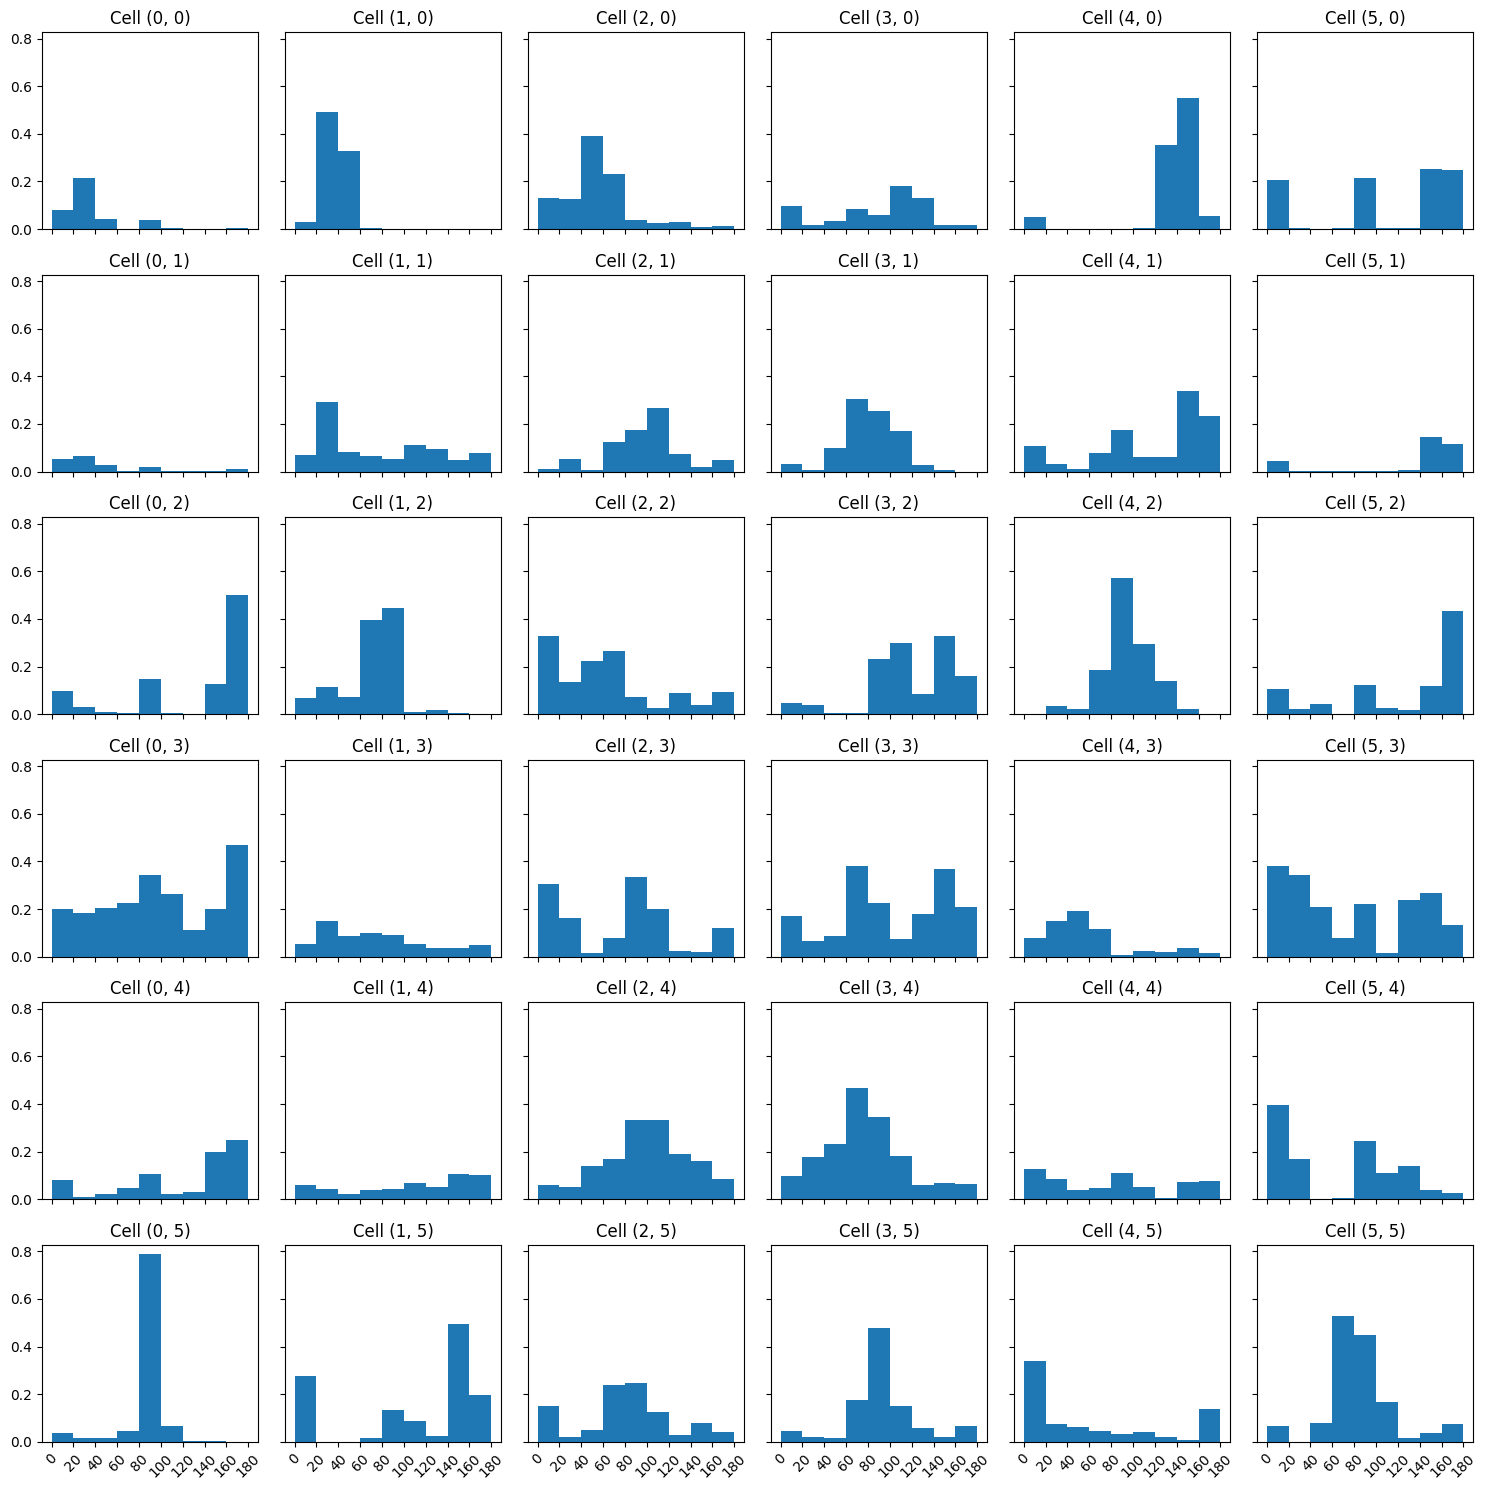

In [27]:
ck_normalized_histograms = block_normalization(ck_histograms, ck_cells_x, ck_cells_y, block_size=(2, 2), plot=True)
plt.savefig('ck-normalized-histogram.png')
plt.show()
# normalized_histograms.shape # (36, 9)

##### jaffe

In [ ]:
block_size=(9,9)

jaffe_normalized_histograms = block_normalization(jaffe_histograms, jaffe_cells_x, jaffe_cells_y, block_size=(9,9), plot=True)
plt.savefig('jaffe-normalized-histogram.png')
plt.show()

### Features

In [122]:
def compute_hog(histograms):

    return histograms.flatten()
    

hog_features = compute_hog(normalized_histograms)
hog_features.shape

(324,)

# Pipelines

### Preprocessing pipeline

In [7]:
from pipelines import preprocessing_pipeline

# images, labels = preprocessing_pipeline(ck_data_path, 'ck')
# images, labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

### HoG pipeline

In [229]:
def hog_pipeline(
    images, 
    bins = 9,
    cell_size = (8, 8),
    block_size= (2, 2),
    resize,
    verbose=False
):

    hog_features_images = []

    for image in tqdm(images):

        magnitude, direction = compute_gradients(image)
        histograms, cells_x, cells_y = compute_histograms(magnitude, direction, cell_size, bins)
        normalized_histograms = block_normalization(histograms, cells_x, cells_y, block_size)
        hog_features_image = compute_hog(normalized_histograms)

        hog_features_images.append(hog_features_image)

    hog_features = np.array(hog_features_images)
    
    if verbose:
        print(f"Bins: {bins}")
        print(f"Cell size: {cell_size}")
        print(f"Block size: {block_size}")
        print(f"Histograms: {histograms.shape[0]}")
        print(f"Features: {hog_features.shape[1]}")

    return hog_features

# hog_features = hog_pipeline(images, verbose=True)

### Classification pipeline

In [225]:
def get_score(clf, X, y, train=True):

    pred = clf.predict(X)
    
    metrics = {
        'accuracy': accuracy_score(y, pred),
        'clf_report': classification_report(y, pred),
        'cm': confusion_matrix(y, pred)
    }

    return pred, metrics


def print_score(y_true, y_pred, train=True, add_cr=False, add_cm=False):

    if train:
        print('================================================')
        print("Train Result:")
    else:
        print('================================================')
        print("Test Result:")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy Score: {accuracy * 100:.2f}%")

    if add_cr:
        clf_report = classification_report(y_true, y_pred)
        print("_______________________________________________")
        print(f"Classification report:\n{clf_report}")

    if add_cm:
        cm = confusion_matrix(y_true, y_pred)
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {cm}\n")
    

def classifier_pipeline(features, labels, verbose=False):

    X_train, X_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size= 0.3,
        random_state=42
    )

    svm_clf = SVC(
        kernel='rbf',
        gamma='scale',
        C= 10 #strength of the regularization is inversely proportional to C
    )
    
    svm_clf.fit(X_train, y_train)

    pred_train, metrics_train = get_score(svm_clf, X_train, y_train, train=True)
    pred_test, metrics_test = get_score(svm_clf, X_test, y_test, train=False)

    if verbose:
        print_score(y_train, pred_train, train=True)
        print_score(y_test, pred_test, train=False)

    return metrics_train, metrics_test

# train_results, test_results = classifier_pipeline(
#     hog_features,
#     labels, 
#     verbose=True
# )

# Final pipeline

In [2]:
from pipelines import hog_pipeline

# Evaluation

### JAFFE dataset

In [14]:
from pipelines import full_hog_pipeline

jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

train_results, test_results = full_hog_pipeline(
    jaffe_data_path, 'jaffe',
    bins = 6, cell_size = (16, 16), block_size = (9, 9), 
    resize=None,
    verbose=True
)

# --- PREPROCESSING ---
# 100%|██████████| 213/213 [00:00<00:00, 800.95it/s]
# Dataset: jaffe
# Dataset length: 213
# Image shape: (256, 256)
# --- HOG ---
# 100%|██████████| 213/213 [00:11<00:00, 19.24it/s]
# Bins: 9
# Cell size: (18, 18)
# Block size: (9, 9)
# Histograms: 196
# Features: 1764
# --- CLASSIF ---
# ================================================
# Train Result:
# Accuracy Score: 100.00%
# ================================================
# Test Result:
# Accuracy Score: 90.62%





--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 877.66it/s]


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- HOG ---


100%|██████████| 213/213 [00:11<00:00, 18.22it/s]


Bins: 6
Cell size: (16, 16)
Block size: (9, 9)
Histograms: 256
Features: 1536
--- CLASSIF ---
Train Result:
Accuracy Score: 99.33%
Test Result:
Accuracy Score: 87.50%


##### cell_size exploration

In [277]:
# train_accuracies = []
# test_accuracies = [] 

# for cell_size in range(4, 16):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = 9, cell_size = (cell_size, cell_size), block_size = (3, 3),
#         verbose=True
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])


# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(4,16), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(4,16), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(4,16))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-cs-search-bins9-bs3x3.png')
# plt.show() 

# # train_accuracies
# # [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# # test_accuracies
# # [0.5625,
# #  0.671875,
# #  0.671875,
# #  0.671875,
# #  0.6875,
# #  0.703125,
# #  0.75,
# #  0.78125,
# #  0.765625,
# #  0.765625,
# #  0.8125, #14
# #  0.796875]

# train_accuracies = []
# test_accuracies = [] 

# for cell_size in range(16, 33):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = 9, cell_size = (cell_size, cell_size), block_size = (3, 3),
#         verbose=True
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])


# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(16, 33), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(16, 33), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(16, 33))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-cs-search16to32-bins9-bs3x3.png')
# plt.show() 


# train_accuracies
# [1.0, #16
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0, # 21
#  1.0,
#  1.0,
#  1.0,
#  0.9932885906040269,
#  1.0,
#  1.0, #27
#  1.0,
#  0.9932885906040269, #29
#  1.0,
#  1.0, #31
#  0.9932885906040269] #32

# test_accuracies 
# [0.796875, #16
#  0.765625,
#  0.859375,
#  0.828125,
#  0.828125,
#  0.875, #21
#  0.859375,
#  0.859375,
#  0.84375,
#  0.84375,
#  0.859375,
#  0.875, #27
#  0.859375,
#  0.875, #29
#  0.859375,
#  0.875, # 31
#  0.84375] #32

##### block_size exploration

In [278]:
# train_accuracies = []
# test_accuracies = [] 

# for block_size in range(1, 16):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = 9, cell_size = (16, 16), block_size = (block_size, block_size),
#         verbose=True
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])


# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(1, 16), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(1, 16), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(1, 16))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-bs-search-bins9-cs16x16.png')
# plt.show() 

# train_accuracies
# [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# test_accuracies
# [0.765625, # 1
#  0.78125,
#  0.796875,
#  0.8125,
#  0.828125,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.875, #9
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375] #15

##### bins exploration

In [246]:
# train_accuracies = []
# test_accuracies = [] 

# for bins in range(1, 19):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = bins, cell_size = (16, 16), block_size = (8, 8),
#         verbose=False
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])

# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(1, 19), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(1, 19), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(1, 19))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-bins-search-cs16x16-bs8x8.png')
# plt.show()    

# train_accuracies
# [0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0]

# test_accuracies
# [0.828125,
#  0.828125,
#  0.859375,
#  0.828125,
#  0.859375,
#  0.859375,
#  0.84375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375]

# GridSearch

### JAFFE

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    *preprocessing_pipeline(jaffe_data_path, 'jaffe'),
    test_size=0.25, random_state=42, shuffle=True
)

100%|██████████| 213/213 [00:00<00:00, 530.45it/s]


In [ ]:
from pipelines import HOGTransformer

hog_sk_pipeline = Pipeline([
    ('hog_features', HOGTransformer(
        orientations=9, 
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        resize=None
    )),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

param_grid = {
    'hog_features__orientations': [6, 9],
    'hog_features__pixels_per_cell': [(4,4), (6,6), (8,8)],
    'hog_features__cells_per_block': [(2,2), (3,3)],
    'hog_features__resize': [(32,32)]
}

grid_search = GridSearchCV(
    estimator=hog_sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=3
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)

y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")

y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")

# Best parameters found by grid search:
# {'hog_features__cells_per_block': (3, 3), 'hog_features__orientations': 6, 'hog_features__pixels_per_cell': (4, 4), 'hog_features__resize': (32, 32)}
# 100%|██████████| 159/159 [00:03<00:00, 50.02it/s]

# Test Result:
# ================================================
# Accuracy Score: 100.00%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        21
#      Disgust       1.00      1.00      1.00        25
#         Fear       1.00      1.00      1.00        22
#    Happiness       1.00      1.00      1.00        23
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      1.00      1.00        26
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           1.00       159
#    macro avg       1.00      1.00      1.00       159
# weighted avg       1.00      1.00      1.00       159

# _______________________________________________
# Confusion Matrix: 
# [[21  0  0  0  0  0  0]
#  [ 0 25  0  0  0  0  0]
#  [ 0  0 22  0  0  0  0]
#  [ 0  0  0 23  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  0  0 26  0]
#  [ 0  0  0  0  0  0 21]]
# 100%|██████████| 54/54 [00:00<00:00, 72.84it/s]

# Test Result:
# ================================================
# Accuracy Score: 85.19%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      0.89      0.94         9
#      Disgust       0.75      0.75      0.75         4
#         Fear       1.00      0.80      0.89        10
#    Happiness       1.00      0.75      0.86         8
#      Neutral       0.82      1.00      0.90         9
#      Sadness       0.50      1.00      0.67         5
#     Surprise       1.00      0.78      0.88         9

#     accuracy                           0.85        54
#    macro avg       0.87      0.85      0.84        54
# weighted avg       0.90      0.85      0.86        54

# _______________________________________________
# Confusion Matrix: 
# [[8 0 0 0 0 1 0]
#  [0 3 0 0 0 1 0]
#  [0 1 8 0 0 1 0]
#  [0 0 0 6 1 1 0]
#  [0 0 0 0 9 0 0]
#  [0 0 0 0 0 5 0]
#  [0 0 0 0 1 1 7]]

In [ ]:
from pipelines import HOGTransformer

hog_sk_pipeline = Pipeline([
    ('hog_features', HOGTransformer(
        orientations=9, 
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        resize=None
    )),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

param_grid = {
    'hog_features__orientations': [6, 9, 10, 12, 18],
    'hog_features__pixels_per_cell': [(8,8), (12,12), (16,16), (18,18), (21,21)],
    'hog_features__cells_per_block': [(2,2), (3,3), (6,6), (9,9), (12,12), (16,16)]
}

grid_search = GridSearchCV(
    estimator=hog_sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=3
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)

y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")

y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")

# Best parameters found by grid search:
# {'hog_features__cells_per_block': (9, 9), 'hog_features__orientations': 6, 'hog_features__pixels_per_cell': (16, 16)}

# Test Result:
# ================================================
# Accuracy Score: 99.33%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        20
#      Disgust       1.00      1.00      1.00        23
#         Fear       1.00      1.00      1.00        20
#    Happiness       0.95      1.00      0.98        21
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      0.96      0.98        23
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           0.99       149
#    macro avg       0.99      0.99      0.99       149
# weighted avg       0.99      0.99      0.99       149

# _______________________________________________
# Confusion Matrix: 
# [[20  0  0  0  0  0  0]
#  [ 0 23  0  0  0  0  0]
#  [ 0  0 20  0  0  0  0]
#  [ 0  0  0 21  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  1  0 22  0]
#  [ 0  0  0  0  0  0 21]]

# Test Result:
# ================================================
# Accuracy Score: 85.94%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       0.88      0.70      0.78        10
#      Disgust       0.56      0.83      0.67         6
#         Fear       1.00      0.58      0.74        12
#    Happiness       1.00      1.00      1.00        10
#      Neutral       1.00      1.00      1.00         9
#      Sadness       0.73      1.00      0.84         8
#     Surprise       0.90      1.00      0.95         9

#     accuracy                           0.86        64
#    macro avg       0.87      0.87      0.85        64
# weighted avg       0.89      0.86      0.86        64

# _______________________________________________
# Confusion Matrix: 
# [[ 7  3  0  0  0  0  0]
#  [ 1  5  0  0  0  0  0]
#  [ 0  1  7  0  0  3  1]
#  [ 0  0  0 10  0  0  0]
#  [ 0  0  0  0  9  0  0]
#  [ 0  0  0  0  0  8  0]
#  [ 0  0  0  0  0  0  9]]

# CrossVal

### CK+

In [41]:
from pipelines import HOGTransformer

ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

hog_sk_pipeline = Pipeline([
    ('hog_features', HOGTransformer(
        orientations=9,
        pixels_per_cell=(8,8), 
        cells_per_block=(2,2),
        resize=None
        )),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(hog_sk_pipeline, ck_images, ck_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 981/981 [00:04<00:00, 213.53it/s]
# SVM MEAN  Accuracy:  99.18%
# Standard deviation:  0.865%

  4%|▍         | 37/981 [00:00<00:02, 362.52it/s]

100%|██████████| 981/981 [00:04<00:00, 213.53it/s]


SVM MEAN  Accuracy:  99.18%
Standard deviation:  0.865%


### JAFFE

In [11]:
from pipelines import HOGTransformer

jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

hog_sk_pipeline = Pipeline([
    ('hog_features', HOGTransformer(
        orientations=6,
        pixels_per_cell=(16,16), 
        cells_per_block=(9,9),
        resize=None
        )),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(hog_sk_pipeline, jaffe_images, jaffe_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 890.03it/s] 
# SVM MEAN  Accuracy:  88.25%
# Standard deviation:  1.630%

 49%|████▉     | 105/213 [00:00<00:00, 1018.07it/s]

100%|██████████| 213/213 [00:00<00:00, 929.30it/s] 


SVM MEAN  Accuracy:  88.25%
Standard deviation:  1.630%


In [9]:
from pipelines import HOGTransformer

jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

hog_sk_pipeline = Pipeline([
    ('hog_features', HOGTransformer(
        orientations=6,
        pixels_per_cell=(4,4), 
        cells_per_block=(3,3),
        resize=(32,32)
        )),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(hog_sk_pipeline, jaffe_images, jaffe_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 886.28it/s]
# SVM MEAN  Accuracy:  80.25%
# Standard deviation:  3.975%

100%|██████████| 213/213 [00:00<00:00, 886.28it/s]


SVM MEAN  Accuracy:  80.25%
Standard deviation:  3.975%
